<a href="https://colab.research.google.com/github/SecrezS/MACDforecasting/blob/main/SPY_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import required libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Download and extract the libta-lib binaries
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1

# Download and extract the Python wrapper for TA-Lib
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

# Import TA-Lib
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4083    0  4083    0     0   7199      0 --:--:-- --:--:-- --:--:--  7201
100  517k  100  517k    0     0   333k      0  0:00:01  0:00:01 --:--:-- 1985k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4111    0  4111    0     0   7485      0 --:--:-- --:--:-- --:--:--  7488
100  392k  100  392k    0     0   281k      0  0:00:01  0:00:01 --:--:-- 1583k


# Step 2: Download data and prepare main dataframe

In [2]:
import yfinance as yf

#Load dataset

# Download data for multiple tickers (SPY, DIA, QQQ, IWM, XLK)
tickers = ["SPY", "DIA", "QQQ", "IWM", "XLK"]
dfs = {}

for ticker in tickers:
    # Download historical data without multi-index column names
    df = yf.download(ticker, start="2012-01-01", end="2024-01-01")
    df.reset_index(inplace=True)

    # Rename columns to remove multi-index formatting and ticker name
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

    # Store the cleaned DataFrame in the dictionary
    dfs[ticker] = df

# Choose the main dataset for demonstration, SPY
data = dfs["SPY"].copy()

data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,Adj Close,Close,High,Low,Open,Volume
0,2012-01-03 00:00:00+00:00,101.091942,127.500000,128.380005,127.430000,127.760002,193697900
1,2012-01-04 00:00:00+00:00,101.250511,127.699997,127.809998,126.709999,127.199997,127186500
2,2012-01-05 00:00:00+00:00,101.520119,128.039993,128.229996,126.430000,127.010002,173895000
3,2012-01-06 00:00:00+00:00,101.258438,127.709999,128.220001,127.290001,128.199997,148050000
4,2012-01-09 00:00:00+00:00,101.504257,128.020004,128.179993,127.410004,128.000000,99530200


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3018 entries, 0 to 3017
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Date       3018 non-null   datetime64[ns, UTC]
 1   Adj Close  3018 non-null   float64            
 2   Close      3018 non-null   float64            
 3   High       3018 non-null   float64            
 4   Low        3018 non-null   float64            
 5   Open       3018 non-null   float64            
 6   Volume     3018 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 165.2 KB


#Step 3: Adding features (technical indicators)

In [4]:
# Calculate RSI
data['RSI'] = talib.RSI(data['Adj Close'], timeperiod=14)

# Calculate Moving Average Convergence Divergence (MACD)
data['MACD'], data['MACD_signal'], data['MACD_diff'] = talib.MACD(data['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)

# Calculate Average True Range (ATR)
data['ATR'] = talib.ATR(data['High'], data['Low'], data['Adj Close'], timeperiod=14)

# Calculate Bollinger Bands (BB)
data['bb_bbm'], data['bb_bbh'], data['bb_bbl'] = talib.BBANDS(data['Adj Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# Calculate Keltner Channel (KC)
data['EMA_KC'] = talib.EMA(data['Adj Close'], timeperiod=20)
data['KC_upper'] = data['EMA_KC'] + (data['ATR'] * 1.5)
data['KC_lower'] = data['EMA_KC'] - (data['ATR'] * 1.5)
data['KC'] = (data['Adj Close'] - data['KC_upper']) / data['Adj Close']
data.drop(columns=['EMA_KC', 'KC_upper', 'KC_lower'], inplace=True)

# Calculate Donchian Channel (DC)
data['DC_upper'] = data['High'].rolling(window=20).max()
data['DC_lower'] = data['Low'].rolling(window=20).min()
data['DC_middle'] = (data['DC_upper'] + data['DC_lower']) / 2

# Calculate On-Balance Volume (OBV)
data['OBV'] = talib.OBV(data['Adj Close'], data['Volume'])

# Calculate Chaikin Money Flow (CMF)
cmf_period = 20
data['Money_Flow_Multiplier'] = ((data['Adj Close'] - data['Low']) - (data['High'] - data['Adj Close'])) / (data['High'] - data['Low'])
data['Money_Flow_Volume'] = data['Money_Flow_Multiplier'] * data['Volume']
data['CMF'] = data['Money_Flow_Volume'].rolling(window=cmf_period).sum() / data['Volume'].rolling(window=cmf_period).sum()
data.drop(columns=['Money_Flow_Multiplier', 'Money_Flow_Volume'], inplace=True)

# Calculate the Stochastic Oscillator
data['stoch_k'], data['stoch_d'] = talib.STOCH(data['High'], data['Low'], data['Adj Close'],
                                               fastk_period=14,  # The %K period
                                               slowk_period=3,   # The %K slowing period
                                               slowk_matype=0,   # Moving average type for %K (0 = SMA)
                                               slowd_period=3,   # The %D period
                                               slowd_matype=0)   # Moving average type for %D (0 = SMA)

# Calculate the Average Directional Index (ADX)
data['ADX'] = talib.ADX(data['High'], data['Low'], data['Adj Close'], timeperiod=14)

# Number of lag days to create
lags = 20

# List of features to create lag features (exlcude "Adj Close")
features_to_lag = ['Volume', 'RSI', 'MACD', 'MACD_signal',
                   'MACD_diff', 'ATR', 'bb_bbm', 'bb_bbh',
                   'bb_bbl', 'KC','DC_upper', 'DC_lower',
                   'DC_middle','OBV','CMF','stoch_k','stoch_d','ADX']

# Function to create lagged features
def create_lagged_features(df, lags, columns):
    for col in columns:
        for lag in range(1, lags + 1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

# Apply lagged features
data = create_lagged_features(data, lags, features_to_lag)
data.dropna(inplace=True)

# Display the data to see the added lagged columns
data.head()

<ipython-input-4-b247fe6fb666>:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{lag}'] = df[col].shift(lag)
<ipython-input-4-b247fe6fb666>:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{lag}'] = df[col].shift(lag)
<ipython-input-4-b247fe6fb666>:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

,Date,Adj Close,Close,High,Low,Open,Volume,RSI,MACD,MACD_signal,...,ADX_lag_11,ADX_lag_12,ADX_lag_13,ADX_lag_14,ADX_lag_15,ADX_lag_16,ADX_lag_17,ADX_lag_18,ADX_lag_19,ADX_lag_20
53,2012-03-20 00:00:00+00:00,111.839790,140.440002,140.610001,139.639999,140.050003,121729700,71.356724,1.443672,1.252662,...,41.814780,43.397554,43.923720,44.490360,45.100588,46.102821,47.324620,47.394768,47.758703,47.692382
54,2012-03-21 00:00:00+00:00,111.656670,140.210007,140.649994,139.919998,140.520004,122388400,69.497480,1.432620,1.288654,...,39.420999,41.814780,43.397554,43.923720,44.490360,45.100588,46.102821,47.324620,47.394768,47.758703
55,2012-03-22 00:00:00+00:00,110.852287,139.199997,139.550003,138.740005,139.179993,135216700,61.871403,1.343468,1.299617,...,36.721962,39.420999,41.814780,43.397554,43.923720,44.490360,45.100588,46.102821,47.324620,47.394768
56,2012-03-23 00:00:00+00:00,111.210686,139.649994,139.809998,138.550003,139.320007,120521000,63.778559,1.286900,1.297073,...,35.165553,36.721962,39.420999,41.814780,43.397554,43.923720,44.490360,45.100588,46.102821,47.324620
57,2012-03-26 00:00:00+00:00,112.771507,141.610001,141.610001,140.600006,140.649994,120164000,70.661127,1.352424,1.308144,...,34.149188,35.165553,36.721962,39.420999,41.814780,43.397554,43.923720,44.490360,45.100588,46.102821


#Step 4: Data Cleaning

In [5]:
#Drop Non-Lagged Technical Indicators

# Define the target column
target_column = 'Adj Close'

# List of non-lagged technical indicators to drop
non_lagged_technical_indicators = [
    'RSI', 'MACD', 'MACD_signal', 'MACD_diff', 'ATR', 'bb_bbm', 'bb_bbh', 'bb_bbl',
    'KC', 'DC_upper', 'DC_lower', 'DC_middle', 'OBV', 'CMF', 'ADX', 'stoch_k', 'stoch_d'
]

# Drop non-lagged columns and other unwanted columns
columns_to_drop = ['Open', 'High', 'Low', 'Close', 'Volume'] + non_lagged_technical_indicators
data = data.drop(columns=columns_to_drop, errors='ignore')



#Step 5: Create features and target variables

In [6]:
X = data.drop(columns=[target_column])  # Drop 'Adj Close' from features
y = data[target_column]  # Set 'Adj Close' as target

#Step 6: Train-test split

In [7]:
# Convert the 'Date' column to datetime format if it's not already
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Assuming data['Date'] has already been converted to datetime and set as index
data_indexed = data.sort_index()  # Make sure the data is sorted by date if not already

# Splitting the data based on dates for training, validation, and testing
train_data = data_indexed[data_indexed.index < "2022-01-01"]
val_data = data_indexed[(data_indexed.index >= "2022-01-01") & (data_indexed.index < "2023-01-01")]
test_data = data_indexed[data_indexed.index >= "2023-01-01"]

# Features and target for training, validation, and testing
X_train = train_data.drop(columns=[target_column])
y_train = train_data[target_column]

X_val = val_data.drop(columns=[target_column])
y_val = val_data[target_column]

X_test = test_data.drop(columns=[target_column])
y_test = test_data[target_column]

#Step 7: Scaling the data

In [8]:
# Instantiate scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale features and target for training, validation, and testing
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape for LSTM input
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

#Step 8: Build and Train the LSTM Model

In [9]:
# Build and Train the LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Output layer for prediction
])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Train the model with validation data
model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_data=(X_val_scaled, y_val_scaled))

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0411 - val_loss: 0.0038
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026 - val_loss: 0.0059
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - val_loss: 0.0173
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020 - val_loss: 0.0051
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - val_loss: 0.0073
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: 0.0059
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: 0.0119
Epoch 10/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - val_loss: 0.0097
Epoch 11/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 0.0129
Epoch 12/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013 - val_

#Step 9: Make Predictions

In [11]:
# Make predictions on the test set
predictions = model.predict(X_test_scaled)

# Inverse scaling of the predictions
predictions = scaler_y.inverse_transform(predictions)

# Inverse scaling of the actual target values for comparison
actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


#Step 10: Evaluate the model

In [12]:
# Calculate performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

rmse = np.sqrt(mean_squared_error(actual, predictions))
mae = mean_absolute_error(actual, predictions)
mape = mean_absolute_percentage_error(actual, predictions)
r2 = r2_score(actual, predictions)

# Display the results
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R² Score: {r2}")

Root Mean Squared Error (RMSE): 18.628557228740224
Mean Absolute Error (MAE): 15.448247436523438
Mean Absolute Percentage Error (MAPE): 0.03721520426844576
R² Score: 0.4007595865650696


#Step 11: Plot the Predictions

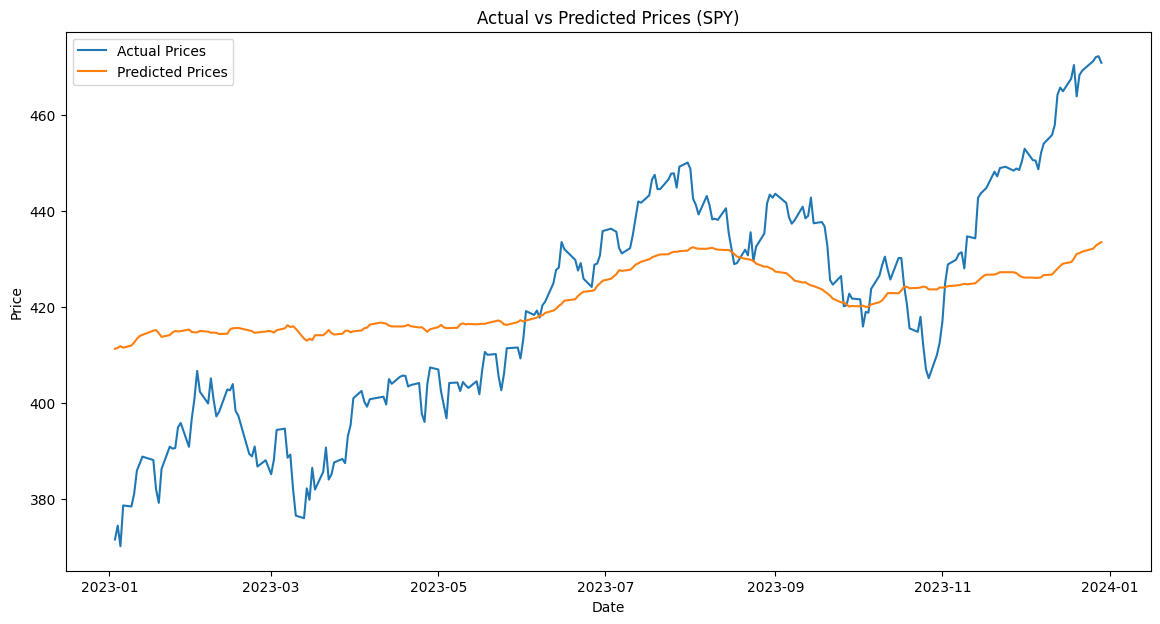

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(test_data.index, y_test, label='Actual Prices')
plt.plot(test_data.index, predictions, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices (SPY)')
plt.legend()
plt.show()